In [1]:
import numpy as np
import math

import xmltodict
from pascal import PascalVOC

import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt

import os
from pathlib import Path

import cv2

import pandas as pd

In [23]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, size = (224, 224), batch_size: int = 32, length: int = 100) -> None:
        super().__init__()
        self.size = np.array(size, dtype=np.int32)
        self.batch_size = batch_size
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        batch_x = []
        batch_y = []

        for i in range(self.batch_size):
            origin = np.full((*self.size, 3), 255, dtype=np.uint8)
            targets = np.zeros((100, 4))

            for k in range(5):
                number = np.random.randint(1, 4)
                if number == 1:
                    center = np.array(np.random.rand(2) * self.size, dtype=np.int32)
                    radius = np.array(np.random.rand(1) * 25 + 15, dtype=np.int32)
                    color = np.random.rand(3) * 255

                    origin = cv2.circle(origin, tuple(center), radius[0], tuple(color), -1)
                    targets[k] = np.array([center[0] - radius[0], center[1] - radius[0], center[0] + radius[0], center[1] + radius[0]], np.float32)

                if number ==  2:
                    center = np.array(np.random.rand(2) * self.size, dtype=np.int32)
                    sides = np.array(np.random.rand(2) * 25 + 15, dtype=np.int32)
                    x_min, y_min, x_max, y_max = [center[0] - sides[0],
                                                  center[1] - sides[1],
                                                  center[0] + sides[0],
                                                  center[1] + sides[1]]
                    color = np.random.rand(3) * 255

                    origin = cv2.rectangle(origin, (x_min, y_min), (x_max, y_max), tuple(color), -1)
                    targets[k] = np.array([x_min, y_min, x_max, y_max], np.float32)

                if number == 3:
                    center = np.array(np.random.rand(2) * self.size, dtype=np.int32)
                    quarters = np.arange(1, 5)
                    np.random.shuffle(quarters)

                    quarter_arr = []
                    for quarter in quarters:
                        if len(quarter_arr) == 3:
                            break

                        sides = np.array(np.random.rand(2) * 25 + 15, dtype=np.int32)

                        if quarter == 1:
                            p1 = tuple([center[0] + sides[0], center[1] + sides[1]])
                            quarter_arr.append(p1)
                            continue
                        if quarter == 2:
                            p2 = tuple([center[0] - sides[0], center[1] + sides[1]])
                            quarter_arr.append(p2)
                            continue
                        if quarter == 3:
                            p3 = tuple([center[0] - sides[0], center[1] - sides[1]])
                            quarter_arr.append(p3)
                            continue
                        if quarter == 4:
                            p4 = tuple([center[0] + sides[0], center[1] - sides[1]])
                            quarter_arr.append(p4)
                            continue

                    color = np.random.rand(3) * 255
                    origin = cv2.drawContours(origin, [np.array([quarter_arr])], 0, tuple(color), -1)

                    max_cords, min_cords = np.amax(quarter_arr, axis=0), np.amin(quarter_arr, axis=0)
                    targets[k] = np.array([max_cords[0], max_cords[1], min_cords[0], min_cords[1]], np.float32)

            batch_x.append(origin)
            batch_y.append(targets)
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        return batch_x, batch_y

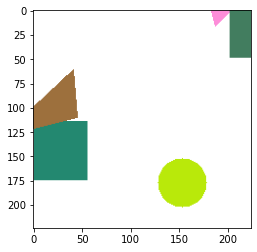

In [24]:
datagen = DataGen()
X, y = datagen.__getitem__(1)

plt.imshow(X[0])

In [12]:
def broadcast_iou(box_1, box_2):
    # box_1: (..., (x1, y1, x2, y2))
    # box_2: (N, (x1, y1, x2, y2))

    # broadcast boxes
    box_1 = tf.expand_dims(box_1, -2)
    box_2 = tf.expand_dims(box_2, 0)
    # new_shape: (..., N, (x1, y1, x2, y2))
    new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
    box_1 = tf.broadcast_to(box_1, new_shape)
    box_2 = tf.broadcast_to(box_2, new_shape)

    int_w = tf.maximum(tf.minimum(box_1[..., 2], box_2[..., 2]) -
                       tf.maximum(box_1[..., 0], box_2[..., 0]), 0)
    int_h = tf.maximum(tf.minimum(box_1[..., 3], box_2[..., 3]) -
                       tf.maximum(box_1[..., 1], box_2[..., 1]), 0)
    int_area = int_w * int_h
    box_1_area = (box_1[..., 2] - box_1[..., 0]) * (box_1[..., 3] - box_1[..., 1])
    box_2_area = (box_2[..., 2] - box_2[..., 0]) * (box_2[..., 3] - box_2[..., 1])
    return int_area / (box_1_area + box_2_area - int_area)

In [13]:
class Loss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        loss = tf.reduce_max(
            broadcast_iou(tf.reshape(y_true, (-1, 4)), tf.reshape(y_pred, (-1, 4))),
            axis=-1)
        return loss

In [14]:
def Convolution(x, filters, kernel, strides, dropout: float = 0.0):
    x = layers.Conv2D(filters, kernel, strides, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    if dropout > 0:
        x = layers.Dropout(dropout)(x)
    return x

In [25]:
inp = layers.Input(shape=(224, 224, 1))

x = Convolution(inp, 16, 3, 1)      # 224x224x16
x = Convolution(x, 32, 3, 2, 0.25)  # 112x112x32
x = Convolution(x, 64, 3, 2, 0.25)  # 56x56x48
x = Convolution(x, 128, 3, 2, 0.25)  # 28x28x56
x = layers.GlobalMaxPooling2D()(x)

x = layers.Dense(400, activation="relu")(x)
bbox = layers.Lambda(lambda x: tf.reshape(x, (-1, 100, 4)))(x)

model = tf.keras.Model(inp, bbox)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=Loss()
)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 16)      160       
                                                                 
 batch_normalization_8 (Batc  (None, 224, 224, 16)     64        
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 224, 224, 16)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_9 (Batc  (None, 112, 112, 32)     128       
 hNormalization)                                           

In [ ]:
model.fit(
    DataGen(),
    epochs=100,
    batch_size=32,
    validation_data=DataGen(),
)

In [ ]:
samples, bboxes = DataGen().__getitem__(1)
sample, bbox = samples[0], bboxes[0]

predictions = model.predict(np.array([sample]))[0]
for index, prediction in enumerate(predictions):
    if np.sum(prediction) == 0:
        continue
    print(f"Prediction: {prediction}, GT: {bbox[index]}")
    prediction = prediction * 224
    x1, y1, x2, y2 = prediction.astype(int)
    cv2.rectangle(sample, (x1, y1), (x2, y2), (255, 0, 0), 3)
plt.imshow(sample)

In [ ]:
gt = DataGen().__getitem__(1)[1].reshape((-1, 4))
dt = DataGen().__getitem__(1)[1].reshape((-1, 4))

print(gt.shape, dt.shape)

broadcast_iou(gt, dt)